<a href="https://colab.research.google.com/github/iaoran/python-data-analysis/blob/main/Copy_of_11_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-text


In [ ]:
!pip install tensorflow-addons


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 32.6 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
!pip uninstall tensorflow -y


Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0


In [ ]:
!pip install tensorflow==2.13.0


In [ ]:
import os
import collections
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_text as text  # 重新尝试导入
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

# Suppressing tf.hub warnings
tf.get_logger().setLevel("ERROR")


ImportError: /usr/local/lib/python3.10/dist-packages/tensorflow_text/core/pybinds/tflite_registrar.so: undefined symbol: _ZN4absl12lts_2023080216raw_log_internal21internal_log_functionB5cxx11E

In [ ]:
!pip install tensorflow==2.13.0 tensorflow-text==2.13.0


In [ ]:
!pip uninstall tensorflow tensorflow-text -y


Found existing installation: tensorflow 2.13.0
Uninstalling tensorflow-2.13.0:
  Successfully uninstalled tensorflow-2.13.0
Found existing installation: tensorflow-text 2.13.0
Uninstalling tensorflow-text-2.13.0:
  Successfully uninstalled tensorflow-text-2.13.0


In [ ]:
import os
import collections
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_text as text  # 重新尝试导入
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

# Suppressing tf.hub warnings
tf.get_logger().setLevel("ERROR")


In [ ]:
from google.colab import files
import zipfile
import os

# 上传图片文件夹和描述文件
uploaded = files.upload()


Saving text.txt to text.txt


In [ ]:
from google.colab import files
import zipfile
import os

# 上传 ZIP 文件
uploaded = files.upload()

Saving image.zip to image.zip


In [ ]:
# 解压 ZIP 文件
for filename in uploaded.keys():
    if filename.endswith('.zip'):
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall('/content/images')  # 解压到指定文件夹

In [ ]:
# 设置图片和描述文件的路径
image_folder = '/content/images/image'  # 解压后的图片文件夹路径
caption_file = '/content/text.txt'  # 上传的文本描述文件路径


In [ ]:
# 读取文本描述
with open(caption_file, 'r') as file:
    lines = file.readlines()
captions = [lines[i:i+5] for i in range(0, len(lines), 5)]  # 每张图像有5个描述

In [ ]:
# 获取图像文件路径列表，并确保数量匹配
image_paths = [os.path.join(image_folder, filename) for filename in sorted(os.listdir(image_folder))]
assert len(image_paths) == len(captions), "图像数量和描述数量不匹配"

In [ ]:
# 创建图像路径和描述的字典
image_path_to_caption = {image_path: caption_set for image_path, caption_set in zip(image_paths, captions)}

In [ ]:
# 加载图像和生成嵌入的辅助函数
def read_image(image_path):
    image_array = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
    return tf.image.resize(image_array, (299, 299))

In [ ]:
# 定义图像和文本编码器
def create_vision_encoder(num_projection_layers=1, projection_dims=256, dropout_rate=0.1, trainable=False):
    xception = keras.applications.Xception(include_top=False, weights="imagenet", pooling="avg")
    for layer in xception.layers:
        layer.trainable = trainable
    inputs = layers.Input(shape=(299, 299, 3), name="image_input")
    xception_input = tf.keras.applications.xception.preprocess_input(inputs)
    embeddings = xception(xception_input)
    outputs = project_embeddings(embeddings, num_projection_layers, projection_dims, dropout_rate)
    return keras.Model(inputs, outputs, name="vision_encoder")

In [ ]:
def create_text_encoder(num_projection_layers=1, projection_dims=256, dropout_rate=0.1, trainable=False):
    preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2", name="text_preprocessing")
    bert = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1", name="bert")
    bert.trainable = trainable
    inputs = layers.Input(shape=(), dtype=tf.string, name="text_input")
    bert_inputs = preprocess(inputs)
    embeddings = bert(bert_inputs)["pooled_output"]
    outputs = project_embeddings(embeddings, num_projection_layers, projection_dims, dropout_rate)
    return keras.Model(inputs, outputs, name="text_encoder")

In [ ]:
# 定义嵌入投影函数
def project_embeddings(embeddings, num_projection_layers, projection_dims, dropout_rate):
    projected_embeddings = layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = layers.Dense(projection_dims)(x)
        x = layers.Dropout(dropout_rate)(x)
        projected_embeddings = layers.Add()([projected_embeddings, x])
    return layers.LayerNormalization()(projected_embeddings)


In [ ]:
class DualEncoder(keras.Model):
    def __init__(self, text_encoder, image_encoder, temperature=1.0, **kwargs):
        super(DualEncoder, self).__init__(**kwargs)
        self.text_encoder = text_encoder
        self.image_encoder = image_encoder
        self.temperature = temperature
        self.loss_tracker = keras.metrics.Mean(name="loss")

    def call(self, inputs, training=False):
        # 确保输入包含 'image' 和 'caption' 两部分
        image_input = inputs["image"]
        caption_input = inputs["caption"]

        # 通过 text_encoder 和 image_encoder 生成嵌入
        caption_embeddings = self.text_encoder(caption_input, training=training)
        image_embeddings = self.image_encoder(image_input, training=training)

        return caption_embeddings, image_embeddings

    def compute_loss(self, caption_embeddings, image_embeddings):
        logits = tf.matmul(caption_embeddings, image_embeddings, transpose_b=True) / self.temperature
        images_similarity = tf.matmul(image_embeddings, image_embeddings, transpose_b=True)
        captions_similarity = tf.matmul(caption_embeddings, caption_embeddings, transpose_b=True)
        targets = tf.keras.activations.softmax((captions_similarity + images_similarity) / (2 * self.temperature))
        captions_loss = keras.losses.categorical_crossentropy(targets, tf.transpose(logits), from_logits=True)
        images_loss = keras.losses.categorical_crossentropy(targets, logits, from_logits=True)
        return (captions_loss + images_loss) / 2

    def train_step(self, data):
        with tf.GradientTape() as tape:
            caption_embeddings, image_embeddings = self(data, training=True)
            loss = self.compute_loss(caption_embeddings, image_embeddings)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        caption_embeddings, image_embeddings = self(data, training=False)
        loss = self.compute_loss(caption_embeddings, image_embeddings)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [ ]:
# 创建并编译模型
dual_encoder = DualEncoder(text_encoder, vision_encoder, temperature=0.05)
dual_encoder.compile(optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001))

In [ ]:
# 训练模型
dual_encoder.fit(dataset, epochs=5)

Epoch 1/5
20/20 [==============================] - 19s 594ms/step - loss: 73.3680
Epoch 2/5
20/20 [==============================] - 13s 679ms/step - loss: 128.8689
Epoch 3/5
20/20 [==============================] - 12s 584ms/step - loss: 40.5158
Epoch 4/5
20/20 [==============================] - 11s 527ms/step - loss: 47.4996
Epoch 5/5
20/20 [==============================] - 11s 575ms/step - loss: 32.0094


In [ ]:
# 保存视觉编码器和文本编码器
vision_encoder.save("vision_encoder")
text_encoder.save("text_encoder")


In [ ]:
# 生成图像嵌入
def generate_image_embeddings(image_paths, batch_size=32):
    def read_image(image_path):
        image_array = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
        return tf.image.resize(image_array, (299, 299))

    print(f"Generating embeddings for {len(image_paths)} images...")
    image_embeddings = vision_encoder.predict(
        tf.data.Dataset.from_tensor_slices(image_paths).map(read_image).batch(batch_size)
    )
    print("Image embeddings shape:", image_embeddings.shape)
    return image_embeddings

image_embeddings = generate_image_embeddings(image_paths)


Generating embeddings for 8 images...
1/1 [==============================] - 3s 3s/step
Image embeddings shape: (8, 256)


83683744/83683744 [==============================] - 5s 0us/step


In [ ]:
def find_matches(image_embeddings, query, k=9, normalize=True):
    # 生成查询的嵌入
    query_embedding = text_encoder(tf.convert_to_tensor([query]))
    query_embedding = tf.math.l2_normalize(query_embedding, axis=1)

    if normalize:
        image_embeddings = tf.math.l2_normalize(image_embeddings, axis=1)

    # 计算查询和图像嵌入之间的点积相似度
    dot_similarity = tf.matmul(query_embedding, image_embeddings, transpose_b=True)

    # 打印 dot_similarity 的形状
    print("Dot similarity shape:", dot_similarity.shape)

    # 确保 dot_similarity 是二维的
    dot_similarity = tf.reshape(dot_similarity, [-1])

    # 获取前 k 个匹配的索引
    results = tf.math.top_k(dot_similarity, k=k).indices.numpy()
    return [image_paths[i] for i in results]


In [ ]:
def find_matches(image_embeddings, query, k=5, normalize=True):
    # 生成查询的嵌入
    query_embedding = text_encoder(tf.convert_to_tensor([query]))
    query_embedding = tf.math.l2_normalize(query_embedding, axis=1)

    # 归一化图像嵌入
    if normalize:
        image_embeddings = tf.math.l2_normalize(image_embeddings, axis=1)

    # 计算查询嵌入与图像嵌入之间的相似度
    dot_similarity = tf.matmul(query_embedding, image_embeddings, transpose_b=True)

    # 打印所有图片的相似度
    print("All image similarities:", dot_similarity.numpy())

    # 获取前 k 个匹配结果
    top_k_indices = tf.math.top_k(dot_similarity, k=k).indices.numpy()
    return [image_paths[i] for i in top_k_indices[0]], dot_similarity.numpy()[0][top_k_indices[0]]


In [ ]:
query = "professional motorcycle racer turn a corner"  # 示例查询，可以替换为你感兴趣的其他描述
matches, similarities = find_matches(image_embeddings, query)




All image similarities: [[-0.02315102  0.02823976 -0.00436408  0.10509007  0.05294828 -0.00915202
   0.06124822 -0.02029246]]


In [ ]:
print("Top matches:", matches)

Top matches: ['/content/images/image/1362128028_8422d53dc4.jpg', '/content/images/image/1478268555_7e301fc510.jpg', '/content/images/image/1383698008_8ac53ed7ec.jpg', '/content/images/image/1351764581_4d4fb1b40f.jpg', '/content/images/image/1358089136_976e3d2e30.jpg', '/content/images/image/1468103286_96a6e07029.jpg', '/content/images/image/161669933_3e7d8c7e2c.jpg', '/content/images/image/1305564994_00513f9a5b.jpg']


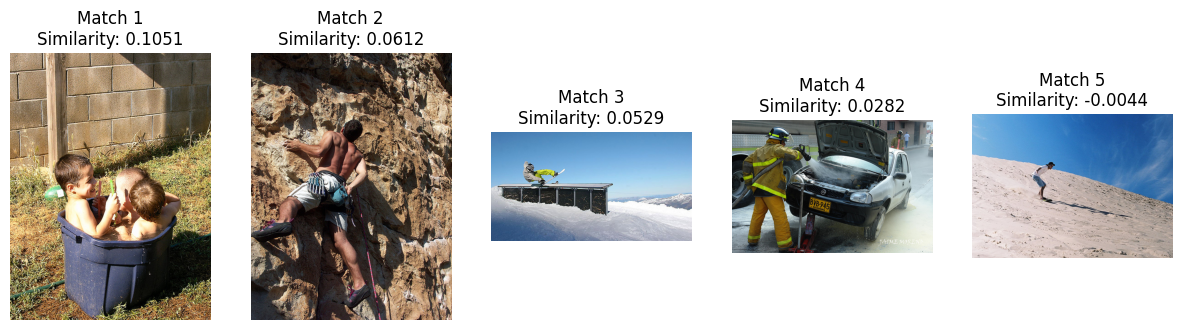

In [ ]:
# 打印相似度最高的图片及其相似度值
plt.figure(figsize=(15, 15))  # 设置图像大小
for i, (image_path, similarity) in enumerate(zip(matches, similarities)):
    img = mpimg.imread(image_path)
    ax = plt.subplot(1, len(matches), i + 1)  # 创建子图
    plt.imshow(img)
    plt.title(f"Match {i+1}\nSimilarity: {similarity:.4f}")
    plt.axis("off")  # 不显示坐标轴

plt.show()

In [ ]:
def find_matches(image_embeddings, query, k=9, normalize=True):
    # 生成查询的嵌入
    query_embedding = text_encoder(tf.convert_to_tensor([query]))
    query_embedding = tf.math.l2_normalize(query_embedding, axis=1)

    if normalize:
        image_embeddings = tf.math.l2_normalize(image_embeddings, axis=1)

    # 计算查询向量与图像向量之间的点积相似度
    dot_similarity = tf.matmul(query_embedding, image_embeddings, transpose_b=True)

    # 打印每个图像的相似度得分
    print("相似度得分:", dot_similarity.numpy()[0])

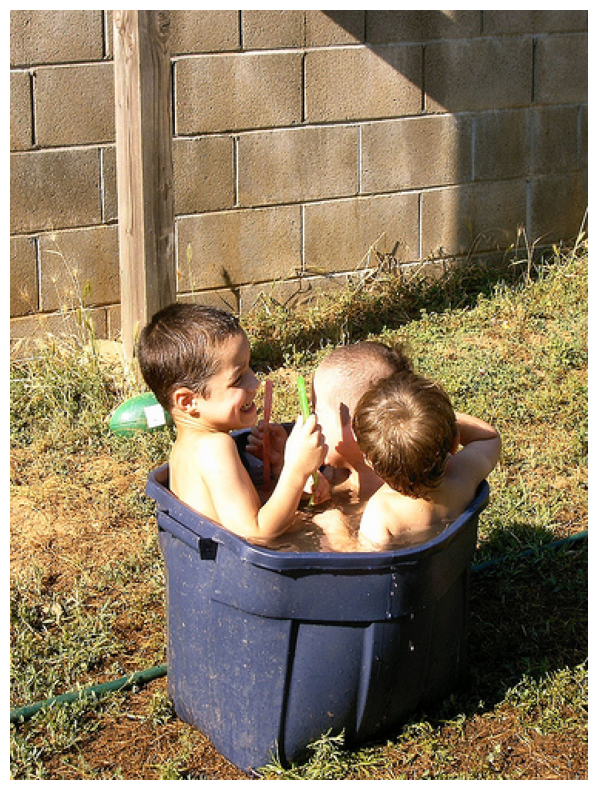

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 显示匹配的前 1 张图像
plt.figure(figsize=(10, 10))  # 调整图像大小

# 只显示第一个匹配项
image_path = matches[0]  # 获取第一张匹配的图片路径
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
print("Dot similarity shape:", dot_similarity.shape)


NameError: name 'dot_similarity' is not defined

In [ ]:
# 示例查询
query = "a person surfing on a sunny beach"
matches = find_matches(image_embeddings, query)


InvalidArgumentError: {{function_node __wrapped__TopKV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} input must have at least k columns. Had 8, needed 9 [Op:TopKV2] name: 

In [ ]:
# 创建训练数据
def preprocess_data(image_paths, captions):
    data = []
    for image_path, caption_set in zip(image_paths, captions):
        for caption in caption_set:
            data.append({"image": read_image(image_path), "caption": caption})
    return data

In [ ]:
train_data = preprocess_data(image_paths, captions)
dataset = tf.data.Dataset.from_generator(lambda: iter(train_data), output_types={'image': tf.float32, 'caption': tf.string})
dataset = dataset.batch(2)  # 每个批次2个样本


In [ ]:
# 训练模型
dual_encoder.fit(dataset, epochs=5)

Epoch 1/5


NotImplementedError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 596, in call
        raise NotImplementedError(

    NotImplementedError: Exception encountered when calling layer 'dual_encoder_2' (type DualEncoder).
    
    Unimplemented `tf.keras.Model.call()`: if you intend to create a `Model` with the Functional API, please provide `inputs` and `outputs` arguments. Otherwise, subclass `Model` with an overridden `call()` method.
    
    Call arguments received by layer 'dual_encoder_2' (type DualEncoder):
      • inputs={'image': 'tf.Tensor(shape=<unknown>, dtype=float32)', 'caption': 'tf.Tensor(shape=<unknown>, dtype=string)'}
      • training=True
      • mask=None


In [ ]:
# 读取描述文件
with open(caption_file, 'r') as file:
    lines = file.readlines()


In [ ]:
# 每张图片有 5 个描述，将描述按 5 行分组
captions = [lines[i:i+5] for i in range(0, len(lines), 5)]

In [ ]:
# 获取图片文件路径列表，并只选择 .jpg 或 .jpeg 文件
image_paths = [os.path.join(image_folder, filename) for filename in sorted(os.listdir(image_folder)) if filename.endswith(('.jpg', '.jpeg'))]

In [ ]:
# 打印图片数量
print("图片数量:", len(image_paths))

图片数量: 8


In [ ]:
# 图片加载和预处理函数
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # 根据模型需求调整图片大小
    image = image / 255.0  # 归一化到[0, 1]范围
    return image

In [ ]:
# 创建图片数据集
image_dataset = tf.data.Dataset.from_tensor_slices(image_paths).map(load_and_preprocess_image)

In [ ]:
# 因为每张图片有 5 个描述，将描述平铺展开
caption_dataset = tf.data.Dataset.from_tensor_slices([desc for group in captions for desc in group])

In [ ]:
# 每张图片需要重复5次，以与5个描述对应
image_dataset = image_dataset.flat_map(lambda x: tf.data.Dataset.from_tensors(x).repeat(5))

In [ ]:
# 将图像和文本数据集组合在一起
dataset = tf.data.Dataset.zip((image_dataset, caption_dataset)).batch(8)  # 批次大小为8

In [ ]:
# 测试数据集，打印前几个批次的图片和描述
for images, texts in dataset.take(1):  # 仅显示一个批次
    print("图片批次的形状:", images.shape)
    print("描述批次:", texts.numpy())

图片批次的形状: (8, 224, 224, 3)
描述批次: [b"1305564994_00513f9a5b.jpg#0\tA man in street racer armor be examine the tire of another racer 's motorbike .\n"
 b'1305564994_00513f9a5b.jpg#1\tTwo racer drive a white bike down a road .\n'
 b'1305564994_00513f9a5b.jpg#2\tTwo motorist be ride along on their vehicle that be oddly design and color .\n'
 b'1305564994_00513f9a5b.jpg#3\tTwo person be in a small race car drive by a green hill .\n'
 b'1305564994_00513f9a5b.jpg#4\tTwo person in race uniform in a street car .\n'
 b'1351764581_4d4fb1b40f.jpg#0\tA firefighter extinguish a fire under the hood of a car .\n'
 b'1351764581_4d4fb1b40f.jpg#1\ta fireman spray water into the hood of small white car on a jack\n'
 b'1351764581_4d4fb1b40f.jpg#2\tA fireman spray inside the open hood of small white car , on a jack .\n']


In [ ]:
from tensorflow.keras import layers
import tensorflow_hub as hub

In [ ]:
# 图像编码器 - 使用预训练的图像模型
def build_image_encoder():
    model = tf.keras.Sequential([
        hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", trainable=False),
        layers.Dense(256, activation="relu")
    ])
    return model

In [ ]:
# 文本编码器 - 使用预训练的文本模型
def build_text_encoder():
    model = tf.keras.Sequential([
        hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=False),
        layers.Dense(256, activation="relu")
    ])
    return model

In [ ]:
# 构建整个双编码器模型
class DualEncoderModel(tf.keras.Model):
    def __init__(self):
        super(DualEncoderModel, self).__init__()
        self.image_encoder = build_image_encoder()
        self.text_encoder = build_text_encoder()

In [ ]:
def call(self, images, texts):
        image_embeddings = self.image_encoder(images)
        text_embeddings = self.text_encoder(texts)
        return image_embeddings, text_embeddings

model = DualEncoderModel()

In [ ]:
# 使用对比损失函数来最小化图像和文本嵌入之间的距离
loss_fn = tf.keras.losses.CosineSimilarity(axis=1)
optimizer = tf.keras.optimizers.Adam()

In [ ]:
# 编译模型
model.compile(optimizer=optimizer, loss=loss_fn)

In [ ]:
class DualEncoderModel(tf.keras.Model):
    def __init__(self):
        super(DualEncoderModel, self).__init__()
        self.image_encoder = build_image_encoder()
        self.text_encoder = build_text_encoder()

    def call(self, images, texts):
        image_embeddings = self.image_encoder(images)
        text_embeddings = self.text_encoder(texts)
        # 计算余弦相似度，并取其平均值作为标量损失
        similarity = tf.keras.losses.cosine_similarity(image_embeddings, text_embeddings, axis=-1)
        return tf.reduce_mean(similarity)


In [ ]:
# 使用均值余弦相似度作为损失函数
loss_fn = lambda y_true, y_pred: y_pred  # y_pred 就是模型的相似度损失
optimizer = tf.keras.optimizers.Adam()

# 编译模型
model.compile(optimizer=optimizer, loss=loss_fn)


In [ ]:
class DualEncoderModel(tf.keras.Model):
    def __init__(self):
        super(DualEncoderModel, self).__init__()
        self.image_encoder = build_image_encoder()
        self.text_encoder = build_text_encoder()

    def call(self, inputs):
        images, texts = inputs  # 从输入元组中解包出 images 和 texts
        image_embeddings = self.image_encoder(images)
        text_embeddings = self.text_encoder(texts)
        similarity = tf.keras.losses.cosine_similarity(image_embeddings, text_embeddings, axis=-1)
        return tf.reduce_mean(similarity)

    def train_step(self, data):
        images, texts = data  # 在 train_step 中解包数据
        with tf.GradientTape() as tape:
            # 前向传播并计算损失
            loss = self((images, texts))  # 传入一个元组
        # 计算梯度并应用优化
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # 返回损失，用于监控
        return {"loss": loss}

# 初始化并编译模型
model = DualEncoderModel()
model.compile(optimizer=optimizer)  # 不需要显式指定损失函数，因为在 train_step 中定义了损失计算


In [ ]:
# 训练模型
model.fit(dataset, epochs=5)


Epoch 1/5
5/5 [==============================] - 7s 170ms/step - loss: -0.4748
Epoch 2/5
5/5 [==============================] - 1s 160ms/step - loss: -0.7924
Epoch 3/5
5/5 [==============================] - 1s 169ms/step - loss: -0.9006
Epoch 4/5
5/5 [==============================] - 1s 160ms/step - loss: -0.9420
Epoch 5/5
5/5 [==============================] - 1s 205ms/step - loss: -0.9605
